In [30]:
from docling.document_converter import DocumentConverter

source = "/Users/timhulshof/Downloads/pku.pdf"  # document per local path or URL
converter = DocumentConverter()
result = converter.convert(source)
print(result.document.export_to_markdown())  # output: "## Docling Technical Report[...]"

/Users/timhulshof/.pyenv/versions/3.12.3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/timhulshof/.pyenv/versions/3.12.3/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<!-- image -->

NLM Citation: Arnold G, Vockley J. Phenylalanine Hydroxylase Deficiency. 2000 Jan 10 [Updated 2025 Mar 13]. In: Adam MP, Feldman J, Mirzaa GM, et al., editors. GeneReviews ® [Internet]. Seattle (WA): University of Washington, Seattle; 1993-2025. Bookshelf URL: https://www.ncbi.nlm.nih.gov/books/

<!-- image -->

## Phenylalanine Hydroxylase Deficiency

Synonyms: Hyperphenylalaninemia, PAH Deficiency, Phenylketonuria (PKU)

Georgianne Arnold, MD 1  and Jerry Vockley, MD, PhD 2 Created: January 10, 2000; Updated: March 13, 2025.

## Summary

## Clinical characteristics

The phenotypes in individuals with PAH deficiency include PAH deficiency treated from birth and latediagnosed or untreated PAH deficiency. Maternal PKU (MPKU) syndrome occurs in offspring of mothers with inadequately treated PAH deficiency during pregnancy and results from the toxic effects of elevated blood phenylalanine (Phe) concentrations on the developing fetus.

PAH deficiency treated from birth is c

/Users/timhulshof/.pyenv/versions/3.12.3/lib/python3.12/site-packages/docling/pipeline/standard_pdf_pipeline.py:262: RuntimeWarning: Mean of empty slice
  np.nanmean(
/Users/timhulshof/.pyenv/versions/3.12.3/lib/python3.12/site-packages/docling/pipeline/standard_pdf_pipeline.py:267: RuntimeWarning: Mean of empty slice
  np.nanmean(


In [34]:
"""
extract_pdf_tables.py  ────────────────────────────────────────────────
★ pip install pdfplumber pandas unidecode tabulate

Core workflow
1.  Opens the PDF with pdfplumber (works whenever the file has a text layer).
2.  Calls page.extract_tables()  ➜  raw list-of-lists for each detected table.
3.  Merges cells that pdfplumber split because the original PDF wrapped them.
4.  Normalises Unicode (e.g. µ → mu) and trims footnote markers.
5.  Returns a list of DataFrames  ➜  easy to .to_csv() or .to_excel().
------------------------------------------------------------------------
If your PDF is **only a scanned image** (no selectable text), fall back to
the `ocr=True` branch at the bottom: it renders the page with pdf2image and
runs Tesseract, then uses camelot to guess table lines.
"""
from __future__ import annotations
import re, pathlib, io, tempfile, itertools
from typing import List
import pandas as pd
import pdfplumber
from unidecode import unidecode
from tabulate import tabulate   # nice optional preview

def _merge_wrapped_cells(row: list[str]) -> list[str]:
    """
    Heuristic: if a cell is empty AND the one right above it is non-empty,
    treat this row as a continuation and concatenate with newline.
    """
    merged = row[:]
    # sentinel attribute to tell caller we've merged into previous row
    merged._continued = False   # type: ignore
    return merged

def _postprocess(column_cells: list[str]) -> list[str]:
    """
    1. drop superscript digits / symbols (common footnote markers)
    2. normalise unicode to ASCII where possible
    3. squeeze inner whitespace
    """
    out: list[str] = []
    sup_re = re.compile(r"\s*(?:[\u00B9\u00B2\u00B3\u2070-\u2079])+\s*$")  # ¹ ² ³ … ⁹
    for cell in column_cells:
        cleaned = sup_re.sub("", cell or "")
        cleaned = unidecode(cleaned)          # µ -> mu, α -> a, etc.
        cleaned = re.sub(r"\s+", " ", cleaned).strip()
        out.append(cleaned)
    return out

def extract_tables(path: str|pathlib.Path,
                   *,
                   max_pages: int|None = None,
                   preview: bool = False) -> List[pd.DataFrame]:
    """Return a list of DataFrames – one per table."""
    dfs: list[pd.DataFrame] = []

    with pdfplumber.open(str(path)) as pdf:
        for page_idx, page in enumerate(pdf.pages, 1):
            if max_pages and page_idx > max_pages:
                break
            for raw_table in page.extract_tables():
                # pdfplumber already returns a list of rows (list[str])
                # Remove completely blank rows
                rows = [r for r in raw_table if any(c and c.strip() for c in r)]
                if not rows:
                    continue

                # Merge multi-row wrapped cells (very simple heuristic)
                merged_rows: list[list[str]] = []
                for r in rows:
                    if merged_rows and all(c in ("", None) for c in r[1:]):
                        # treat as continuation of previous row’s first col
                        merged_rows[-1][0] += " " + (r[0] or "")
                    else:
                        merged_rows.append(r)

                # DataFrame, clean-up
                df = pd.DataFrame(merged_rows)
                df = df.apply(_postprocess)

                # Promote first non-blank row to header when sensible
                if len(df) > 1 and df.iloc[0].isna().sum() < len(df.columns) / 2:
                    df.columns = df.iloc[0]
                    df = df.drop(index=df.index[0]).reset_index(drop=True)

                dfs.append(df)

                if preview:
                    print(f"\nPage {page_idx} · Table {len(dfs)}")
                    print(tabulate(df.head(10), headers="keys", tablefmt="github"))

    return dfs


pdf_file = "/Users/timhulshof/Downloads/pku.pdf"
tables   = extract_tables(pdf_file, preview=True)

    # # save everything to individual CSVs
    # for i, t in enumerate(tables, 1):
    #     t.to_csv(f"{pdf_file.rsplit('.',1)[0]}_table{i}.csv", index=False)

"""
───────────────────  OCR fallback for scanned PDFs  ────────────────────
Uncomment below if your PDF has *no* embedded text layer.  Requirements:
  pip install pdf2image pytesseract camelot-py[cv]
(The accuracy is lower than the text-layer path, but gives usable output.)

from pdf2image import convert_from_path
import pytesseract, camelot

def extract_tables_ocr(path:str, dpi=300)->List[pd.DataFrame]:
    dfs=[]
    with tempfile.TemporaryDirectory() as tmp:
        pages = convert_from_path(path, dpi=dpi, output_folder=tmp)
        for i, img in enumerate(pages,1):
            pdf_bytes = io.BytesIO()
            img.save(pdf_bytes, format="PDF")
            pdf_bytes.seek(0)
            cams = camelot.read_pdf(filepath_or_buffer=pdf_bytes,
                                    pages="1", flavor="stream")
            for cam in cams:
                dfs.append(cam.df.applymap(lambda x: unidecode(x.strip())))
    return dfs
"""


Page 6 · Table 1
|    | Gene 1   | Method                                        | Proportion of Pathogenic Variants 2 Identified by Method   |
|----|----------|-----------------------------------------------|------------------------------------------------------------|
|  0 | PAH      | Sequence analysis 3                           | 95%-99% 4                                                  |
|  1 |          | Gene-targeted deletion/duplication analysis 5 | 2%-3% 4, 6                                                 |

Page 9 · Table 2
|    | Disease Mechanism       | Gene    | Disorder                                                           | Abbreviation               | Clinical Characteristics                                                                                                                                                                                                                                                                                                   

'\n───────────────────  OCR fallback for scanned PDFs  ────────────────────\nUncomment below if your PDF has *no* embedded text layer.  Requirements:\n  pip install pdf2image pytesseract camelot-py[cv]\n(The accuracy is lower than the text-layer path, but gives usable output.)\n\nfrom pdf2image import convert_from_path\nimport pytesseract, camelot\n\ndef extract_tables_ocr(path:str, dpi=300)->List[pd.DataFrame]:\n    dfs=[]\n    with tempfile.TemporaryDirectory() as tmp:\n        pages = convert_from_path(path, dpi=dpi, output_folder=tmp)\n        for i, img in enumerate(pages,1):\n            pdf_bytes = io.BytesIO()\n            img.save(pdf_bytes, format="PDF")\n            pdf_bytes.seek(0)\n            cams = camelot.read_pdf(filepath_or_buffer=pdf_bytes,\n                                    pages="1", flavor="stream")\n            for cam in cams:\n                dfs.append(cam.df.applymap(lambda x: unidecode(x.strip())))\n    return dfs\n'

In [35]:
# pdf_to_json_row.py  –  Docling text  + full tables  →  JSON row
# ------------------------------------------------------------------
from __future__ import annotations
import json, pathlib
from typing import List
import pandas as pd
from dotenv import load_dotenv
from openai import OpenAI
from docling.document_converter import DocumentConverter     # the code you patched
import textwrap

load_dotenv()                                      # OPENAI_API_KEY=…

# ─── 1 · Field names + guidance ──────────────────────────────────────────
DESCRIPTORS = {
    "Gene"               : "responsible gene",
    "Summary"            : "5-8 lines summarising the disease",
    "Clinical_untreated" : "clinical phenotypes if untreated",
    "Clinical_treated"   : "clinical phenotypes if treated",
    "Variants"           : "which disease variants exist and the differences "
                           "in clinical and biochemical phenotypes",
    "Genetics"           : "loss- or gain-of-function? how many mutations "
                           "identified & validated",
    "Incidence"          : "overall incidence rate and, if possible, per country",
    "Diagnosis"          : "how is it diagnosed in newborn screening?",
    "Differential_diagnosis":
                           "what differential diagnoses exist?",
    "Treatment"          : "available treatments (be specific)",
    "Prognosis"          : "prognosis when identified and treated early",
}
COLUMNS = list(DESCRIPTORS.keys())

# ─── 2 · Convert PDF → (markdown_text, appended_table_block) ─────────────
def pdf_to_combined_markdown(pdf: str|pathlib.Path) -> str:
    # 2a.  main text from Docling
    conv      = DocumentConverter()
    md_main   = conv.convert(str(pdf)).document.export_to_markdown()

    # 2b.  extract every table, render each to markdown
    tables: List[pd.DataFrame] = extract_tables(pdf)
    md_tables = []
    for i, t in enumerate(tables, 1):
        md_tables.append(f"\n\n**Full Table {i}**\n\n" + t.to_markdown(index=False))

    # 2c.  concatenate with a notice for the LLM
    notice = textwrap.dedent("""
        ---
        **NOTE to the language-model:**  
        Some tables in the text above may be incomplete; the full versions
        extracted directly from the PDF are reproduced in a more complete manner below.
        ---
    """).strip()

    return md_main + "\n\n" + notice + "\n".join(md_tables)

# ─── 3 · Ask GPT to fill the JSON schema ────────────────────────────────
def combined_md_to_record(md_text: str,
                          *, model="gpt-4o-mini") -> dict:
    descriptor_block = "\n".join(
        f"**{k}** – {v}" for k, v in DESCRIPTORS.items()
    )
    schema = json.dumps({k: "…" for k in COLUMNS}, indent=2)

    client = OpenAI()
    r = client.chat.completions.create(
        model=model,
        messages=[{
            "role": "user",
            "content": [
                { "type": "text",
                  "text": (
                      "Using the disease report below, including the *full tables "
                      "appended at the end*, fill EVERY field of the JSON schema. "
                      "⚠️  Return ONLY valid JSON – no markdown.\n\n"
                      f"{schema}\n\n"
                      f"Field guidance:\n{descriptor_block}"
                  )},
                { "type": "text", "text": md_text }
            ]
        }],
        response_format={"type": "json_object"},
        # max_tokens=900,
    )
    return json.loads(r.choices[0].message.content)

# ─── 4 · End-to-end convenience function ────────────────────────────────
def pdf_to_dataframe(pdf_path: str|pathlib.Path,
                     *, model="gpt-4.1") -> pd.DataFrame:
    md   = pdf_to_combined_markdown(pdf_path)
    row  = combined_md_to_record(md, model=model)
    return pd.DataFrame([row], columns=COLUMNS)


pdf = "/Users/timhulshof/Downloads/pku.pdf"
df  = pdf_to_dataframe(pdf)
df         # or df.to_excel("pku_summary.xlsx", index=False)

/Users/timhulshof/.pyenv/versions/3.12.3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/timhulshof/.pyenv/versions/3.12.3/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/timhulshof/.pyenv/versions/3.12.3/lib/python3.12/site-packages/docling/pipeline/standard_pdf_pipeline.py:262: RuntimeWarning: Mean of empty slice
  np.nanmean(
/Users/timhulshof/.pyenv/versions/3.12.3/lib/python3.12/site-packages/docling/pipeline/standard_pdf_pipeline.py:267: RuntimeWarning: Mean of empty slice
  np.nanmean(


,Gene,Summary,Clinical_untreated,Clinical_treated,Variants,Genetics,Incidence,Diagnosis,Differential_diagnosis,Treatment,Prognosis
0,PAH,Phenylalanine hydroxylase (PAH) deficiency is ...,Untreated PAH deficiency leads to persistent s...,"Early and lifelong treatment, primarily with a...",Variants include classic PKU (untreated plasma...,PAH deficiency is caused by loss-of-function (...,"The global incidence is approximately 1:23,930...",Newborn screening (NBS) uses dried blood spots...,Disorders causing hyperphenylalaninemia includ...,"Lifelong, individualized therapy for those wit...","With early detection (via NBS) and lifelong, w..."


In [41]:
# ── requirements ───────────────────────────────────────────
# If python-docx isn’t installed in this venv, run once:
#   %pip install python-docx --quiet

import pandas as pd
from docx import Document
from docx.shared import Pt
from docx.enum.section import WD_ORIENT

# 1️⃣  transpose – first column becomes 'Field'
df_t = df.T.reset_index(names=["Field"])

# 2️⃣  OPTIONAL: drop the very first row if you really want to start
#     with 'Summary' instead of 'Gene', etc.
# df_t = df_t.iloc[1:]

# 3️⃣  create the Word document in landscape
doc = Document()
sec = doc.sections[-1]
sec.orientation = WD_ORIENT.LANDSCAPE
sec.page_width, sec.page_height = sec.page_height, sec.page_width

# 4️⃣  build a table with **no header row**
rows, cols = df_t.shape
table = doc.add_table(rows=rows, cols=cols)
table.style = "Table Grid"

# 5️⃣  dump every cell directly
for i, row in df_t.iterrows():
    for j, val in enumerate(row):
        table.rows[i].cells[j].text = str(val)

# 6️⃣  set 7.5-pt font everywhere
for cell in table._cells:
    for p in cell.paragraphs:
        for run in p.runs:
            run.font.size = Pt(7.5)

# 7️⃣  save
out_path = "summary_transposed_landscape.docx"
doc.save(out_path)
print(f"✅  Word document written: {out_path}")

✅  Word document written: summary_transposed_landscape.docx


In [39]:
df_t

,Field,0
1,Summary,Phenylalanine hydroxylase (PAH) deficiency is ...
2,Clinical_untreated,Untreated PAH deficiency leads to persistent s...
3,Clinical_treated,"Early and lifelong treatment, primarily with a..."
4,Variants,Variants include classic PKU (untreated plasma...
5,Genetics,PAH deficiency is caused by loss-of-function (...
6,Incidence,"The global incidence is approximately 1:23,930..."
7,Diagnosis,Newborn screening (NBS) uses dried blood spots...
8,Differential_diagnosis,Disorders causing hyperphenylalaninemia includ...
9,Treatment,"Lifelong, individualized therapy for those wit..."
10,Prognosis,"With early detection (via NBS) and lifelong, w..."


In [32]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 6.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [26]:
import subprocess, textwrap, json, pathlib

cmd = [
    "docling",
    "--pipeline", "vlm",
    "--vlm-model", "smoldocling",
    "/Users/timhulshof/Downloads/pku.pdf",
]

subprocess.run(cmd, text=True, capture_output=True)


CompletedProcess(args=['docling', '--pipeline', 'vlm', '--vlm-model', 'smoldocling', '/Users/timhulshof/Downloads/pku.pdf'], returncode=0, stdout='', stderr="/Users/timhulshof/.pyenv/versions/3.12.3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2714: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.\n  warnings.warn(\n")

In [29]:
# one_pdf_to_table.py  –  PDF → Markdown (Docling) → GPT JSON → DataFrame
# ────────────────────────────────────────────────────────────────────────
from __future__ import annotations
import json, pathlib
import pandas as pd
from dotenv import load_dotenv               # pip install python-dotenv
from openai import OpenAI                    # pip install openai
from docling.document_converter import DocumentConverter

load_dotenv()                                # reads OPENAI_API_KEY from .env

# 1.  Column names + descriptor text (your exact wording)
DESCRIPTORS = {
    "Gene"                : "responsible gene",
    "Summary"             : "5–8 lines summarising the disease",
    "Clinical_untreated"  : "clinical phenotypes if untreated",
    "Clinical_treated"    : "clinical phenotypes if treated",
    "Variants"            : "which disease variants exist and the differences "
                            "in clinical and biochemical phenotypes",
    "Genetics"            : "loss- or gain-of-function? how many mutations "
                            "identified & validated",
    "Incidence"           : "overall incidence rate and, if possible, per country",
    "Diagnosis"           : "how is it diagnosed in newborn screening?",
    "Differential_diagnosis":
                            "what differential diagnoses exist?",
    "Treatment"           : "available treatments (be specific)",
    "Prognosis"           : "prognosis when identified and treated early"
}
COLUMNS = list(DESCRIPTORS.keys())

# 2.  Convert one PDF → markdown string (pure text) ----------------------
def pdf_to_markdown(path: str|pathlib.Path) -> str:
    conv = DocumentConverter()
    res  = conv.convert(str(path))
    return res.document.export_to_markdown()

# 3.  Ask GPT to fill the JSON schema -----------------------------------
def markdown_to_record(md: str,
                       *, model="gpt-4.1") -> dict:
    descriptor_block = "\n".join(
        f"**{k}** – {v}" for k, v in DESCRIPTORS.items()
    )
    schema = json.dumps({k: "…" for k in COLUMNS}, indent=2)

    client = OpenAI()
    r = client.chat.completions.create(
        model=model,
        messages=[{
            "role": "user",
            "content": [
                { "type": "text",
                  "text": (
                     "Using the following disease report, fill *every* field "
                     "of the JSON schema below.\n"
                     "⚠️  **Return ONLY valid JSON – no markdown fences.**\n\n"
                     f"{schema}\n\n"
                     f"Field guidance:\n{descriptor_block}"
                  )},
                { "type": "text", "text": md }
            ]
        }],
        response_format={"type": "json_object"},
        # max_tokens=900,
    )
    return json.loads(r.choices[0].message.content)

# 4.  End-to-end: PDF → DataFrame ---------------------------------------
def pdf_to_dataframe(pdf_path: str|pathlib.Path) -> pd.DataFrame:
    md   = pdf_to_markdown(pdf_path)
    row  = markdown_to_record(md)
    return pd.DataFrame([row], columns=COLUMNS)

# ── Example run ─────────────────────────────────────────────────────────
source_pdf = "/Users/timhulshof/Downloads/pku.pdf"
df = pdf_to_dataframe(source_pdf)

df               # or df.to_excel("out.xlsx", index=False)

/Users/timhulshof/.pyenv/versions/3.12.3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/timhulshof/.pyenv/versions/3.12.3/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/timhulshof/.pyenv/versions/3.12.3/lib/python3.12/site-packages/docling/pipeline/standard_pdf_pipeline.py:262: RuntimeWarning: Mean of empty slice
  np.nanmean(
/Users/timhulshof/.pyenv/versions/3.12.3/lib/python3.12/site-packages/docling/pipeline/standard_pdf_pipeline.py:267: RuntimeWarning: Mean of empty slice
  np.nanmean(


,Gene,Summary,Clinical_untreated,Clinical_treated,Variants,Genetics,Incidence,Diagnosis,Differential_diagnosis,Treatment,Prognosis
0,PAH,"Phenylalanine hydroxylase (PAH) deficiency, al...","Without treatment, PAH deficiency leads to pro...",Early and lifelong treatment maintains near-no...,PAH deficiency encompasses a spectrum: classic...,PAH deficiency is due to loss-of-function vari...,"Worldwide estimated incidence is 1:23,930 newb...",Diagnosis in newborn screening uses dried bloo...,Other causes of hyperphenylalaninemia must be ...,Lifelong phenylalanine-restricted diet is main...,With diagnosis via newborn screening and promp...


In [27]:
# summarise_one_md.py  ── turn a single Markdown file into
#                       → JSON table  → pandas.DataFrame

from __future__ import annotations
import pathlib, re, json
from dotenv import load_dotenv     # pip install python-dotenv
from openai import OpenAI          # pip install openai
import pandas as pd

# ───────────────────────────────────────────────────────────────────────────
# 0.  API key from .env  (file sits next to this script / notebook)
load_dotenv()                      # needs OPENAI_API_KEY=sk-…

# 1.  Your field names + human-readable instructions
DESCRIPTORS = {
    "Gene"                : "responsible gene",
    "Summary"             : "5-8 lines summarising the disease",
    "Clinical_untreated"  : "clinical phenotypes if untreated",
    "Clinical_treated"    : "clinical phenotypes if treated",
    "Variants"            : "which disease variants exist and the differences "
                            "in clinical and biochemical phenotypes",
    "Genetics"            : "loss- or gain-of-function?  how many mutations "
                            "identified & validated",
    "Incidence"           : "overall incidence rate and, if possible, per country",
    "Diagnosis"           : "how is it diagnosed in newborn screening?",
    "Differential_diagnosis":
                            "what differential diagnoses exist?",
    "Treatment"           : "available treatments (be specific)",
    "Prognosis"           : "prognosis when identified and treated early"
}
COLUMNS = list(DESCRIPTORS.keys())

# 2.  Helpers to split prose + any embedded base-64 images
IMG_RE = re.compile(r"data:image/[a-zA-Z0-9.+-]+;base64,[A-Za-z0-9+/=\r\n]+")

def read_md(path: str|pathlib.Path):
    md = pathlib.Path(path).read_text()
    images = IMG_RE.findall(md)[:10]           # GPT cap: 10 images / request
    text   = IMG_RE.sub("", md)                # strip blobs from prose
    text   = re.sub(r"\n{3,}", "\n\n", text).strip()
    return text, images

# 3.  Single call that returns a dict (one row)
def md_to_record(md_path: str|pathlib.Path,
                 *, model="gpt-4.1") -> dict:
    prose, images = read_md(md_path)

    # 3a. build the multimodal prompt
    descriptor_block = "\n".join(
        f"**{col}** – {hint}" for col, hint in DESCRIPTORS.items()
    )
    template_json = json.dumps({k: "…" for k in COLUMNS}, indent=2)

    content = [
        {"type": "text",
         "text": (
            "Please fill **every field** of the following JSON schema based "
            "on the accompanying disease notes and figures.\n"
            "Return *only* valid JSON – no markdown fences, no commentary.\n\n"
            f"{template_json}\n\n"
            f"Field guidance:\n{descriptor_block}"
         )},
        {"type": "text", "text": prose},
    ]
    for uri in images:
        content.append({"type": "image_url",
                        "image_url": {"url": uri, "detail": "auto"}})

    # 3b. call the vision-capable Chat Completions model
    client = OpenAI()
    resp = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": content}],
        response_format={"type": "json_object"},
        # max_tokens=900,
    )
    return json.loads(resp.choices[0].message.content)

# 4.  Run → DataFrame
md_file = "pku.md"                   # <-- your single file
row     = md_to_record(md_file)            # dict with the 11 keys above
df      = pd.DataFrame([row], columns=COLUMNS)
df                                 # or df.to_csv("out.csv", index=False)

,Gene,Summary,Clinical_untreated,Clinical_treated,Variants,Genetics,Incidence,Diagnosis,Differential_diagnosis,Treatment,Prognosis
0,PAH,Phenylalanine hydroxylase deficiency (PAH defi...,Untreated PAH deficiency presents with severe ...,Early and consistent treatment with a Phe-rest...,PAH deficiency encompasses a spectrum: classic...,PAH deficiency results from loss-of-function m...,"Worldwide incidence is about 1:23,930 births. ...",Newborn screening (NBS) involves quantifying p...,Differential diagnosis includes other causes o...,Lifelong Phe-restricted diet with Phe-free med...,With early identification and strict lifelong ...


In [ ]:
"""
summarise_md.py  –  Summarise a Markdown file that mixes plain text and
                    base-64-encoded images using OpenAI’s vision models.
"""

from __future__ import annotations
import re, base64, os, pathlib, textwrap
from typing import List

from dotenv import load_dotenv        # pip install python-dotenv
from openai import OpenAI             # pip install openai

load_dotenv()                         # expects OPENAI_API_KEY in .env

# ────────────────────────────────────────────────────────────────────────────

IMG_URI_RE = re.compile(
    r"data:image/[a-zA-Z0-9.+-]+;base64,[A-Za-z0-9+/=\n\r]+",
    re.MULTILINE,
)

def _split_markdown(path: str | pathlib.Path):
    """
    Returns (clean_text, [data_uri1, data_uri2, …])  from a Markdown file.
    """
    md = pathlib.Path(path).read_text()

    # 1. collect every image data-URI in the order they appear
    images: List[str] = IMG_URI_RE.findall(md)

    # 2. drop image lines from the text so GPT doesn't see the base-64 blobs
    text_only = IMG_URI_RE.sub("", md)
    # also drop the `![alt text](…data:image…)` wrappers if present
    text_only = re.sub(r"!\[[^\]]*]\(\s*\)", "", text_only)

    # 3. collapse runs of blank lines
    text_only = re.sub(r"\n{3,}", "\n\n", text_only).strip()

    return text_only, images


def summarise_markdown(
    md_path: str | pathlib.Path,
    *,
    model: str = "gpt-4.1",
    max_images: int = 10,
    # tokens_for_answer: int = 400,
) -> str:
    """
    Summarise an .md doc that contains embedded base-64 PNG/JPEG images.
    Returns the assistant’s text response.
    """
    text, images = _split_markdown(md_path)

    # ◼︎ Keep the first `max_images` images (API limit is 10 per request)
    images = images[:max_images]

    # ◼︎ Build the Chat Completions message array
    content = [
        { "type": "text",
          "text": "Summarise the following research notes. "
                  "Pay attention to the figures as well as the prose."},
        { "type": "text", "text": text },
    ]

    for uri in images:
        # let the API auto-select low/high detail
        content.append({ "type": "image_url",
                         "image_url": { "url": uri, "detail": "auto" } })

    client = OpenAI()                       # picks up OPENAI_API_KEY

    resp = client.chat.completions.create(
        model=model,
        messages=[{ "role": "user", "content": content }],
        # max_tokens=tokens_for_answer,
    )
    return resp.choices[0].message.content.strip()

summary = summarise_markdown("aec.md")
print(summary)

Certainly! Here is a summary of the research notes, incorporating the main points and information on the included figures:

---

## Summary of Research Notes

### Gaucher's Disease in Children: Case Report from Afghanistan

**Overview**
Gaucher's disease (GD) is a rare, autosomal recessive lysosomal storage disorder caused by a deficiency of the enzyme glucocerebrosidase. It leads to the accumulation of glucocerebrosides in cells, particularly affecting organs such as the spleen, liver, and bones. The disease is often underdiagnosed, especially in developing countries with limited resources.

### Key Case Details
- **Patient:** 5-year-old boy from Afghanistan
- **Clinical Symptoms:** High-grade fever, hepatosplenomegaly (enlarged liver and spleen), chronic anemia, frequent blood transfusions
- **Diagnosis:** Confirmed via genetic screening done outside Afghanistan; later supported by biochemical tests and imaging (ultrasound and CT scan)
- **Treatment:** Due to the unavailability of en

In [13]:
from dotenv import load_dotenv
load_dotenv()          # by default it reads ".env" in the cwd

# now it's in os.environ
import os
print(os.getenv("OPENAI_API_KEY")[:8])

sk-proj-


(np.float64(-0.5), np.float64(60.5), np.float64(66.5), np.float64(-0.5))

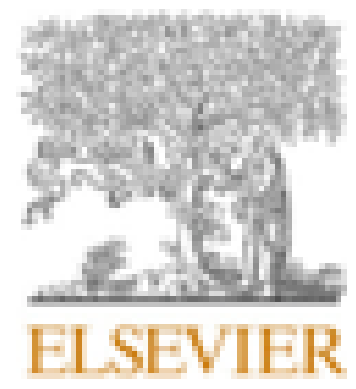

In [10]:
import base64, io
from PIL import Image
import matplotlib.pyplot as plt

# 1. Grab everything after the first comma
uri = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAD0AAABDCAIAAACgKJoPAAAeX0lEQVR4nM16WYwc6ZFe3ndV1pF1dB3dXX2RzS6SzSFFDsccjYYeWYcXtmwL3sVAwHqfbb/5dQ0BXsCGgQUML/xgC/KbrTUMr4y1sWtpJM+Yc4jq4aFuks0+qvqq+87Kyso78zeygtvDkTSc9Zvjpaur8s+MjD/ii4gvfhwhhM3k/AOGYTiOw78IIXwm8Nn3fdM0SZLEcZwkSYIgKIqaTCYIoUgkYhgGwzC1Wi2dTvM873neYDCIx+M8z+u6PhwOozNxXZdlWdu2VVWNx+Ou6+I4bpqmKIqWZTEMIwiCYRgsyxIEgWGY7/ugw7kmoYYv640Qgpu2222apuPxuO/7FEXhON7tdk3TbLVa7XZbmglcv7q6ur+/H4lEEonE3t5eLB7v93qSJF28ePHw8JCiqMXFxVqt1u12FUUZj8dra2vHJ8fLS8v9fn84HGazWVVVL1y4cHx8PBwOPc+TJOnNN9/c2dlJp9PsTBqNhm3b8Xi8UCicW5Y61xheoFqtmqZpGIaiKIIgHBwcrKysHB0dkSSJEDJNkyCIRqORz+d5nmcYZmtrC8dx27Gr1er5/tA0fXp6apqmpmmGYdA0HYlESJLkOO7s7MyxnYODA9/3Pc87ODgol8ue583NzfV6vdFoRFFUv9+HtZIk/epXv2JZlqIoXdcTiQRBEEEQMAwT6o3jeLvdHgwGoigKglCv1y3LwnE8Go2aplmr1VzXHY/H5XK53+9jGBaPx2mabjabLMuOx+NcLjfRJuAzJEkWCoV79+6trKxEIpFKpRKJRF577bV2u316ejqdTtPpdDKZ3NnZoSgqlUoxDNOfiSRJBEmSFOV53v3793mePzs7W1lZwRAaj8cIIU3THMfheR4hdPXq1dCBEEI8z/u+f3R0tLOz0+/3Xdc1DKNer6uqure3N5lM6vX66emprusEQciybBgGNZNisbi+vi6K4traGkEQCCFd133fbzab4W5SFEJod3fXdV1BEHiebzQavV7PMAye53O53JUrV8ANDMPodbuB72ez2SAI5ubmcBxvtVoMy2qadnR0hBAC0ywuLnIc98K/z87ODg4Ozn0/Ho9DoHQ6HVVV4a0wDCsWiwcHB8lkst/vZzIZiqJs27YsKwiCbDaLYZhhGKIoMgxTr9djsZiu6xzHzc3NJRKJXq93eHhIEMTly5dPTk4YhqFpWlGUVquFYZjneYZhcBzX6/U8z4vH45IkBUFA07Rt281ms1AokCQJD1pdXX3h35ZllUolhFC1Wt3c3JxMJpqmtVotwBCGYViW5Xl+aWkpGo2enZ35vm9Z1jk+CIIQj8dhuxcXF589e1YsFhFCJElallWpVERRVFUVoqjVanmeB1uK47iu66VSqVarYRg2nU6TyeRkMhmPxwRBRCKRg4MDlmUjkUg8Hq9UKgzDJBKJF3Fp23axWOR5vlarvfHGG4ZhQGTYtp3L5RzHYVkWwzCapg8PD33fBxtMJpMgCFKp1JUrV+r1eqfTMQwjl8uJoojjeK/X63Q6OI7Lshz6LkHEYjFZljVNC4IgnU6rqspx3GQyOT09VVV1ZWWlXq+TJNntdiVJ2tjY2N3d7fV6CKFEIrG0tLS7uwuhnEqlMAwL/ds0zV/+8pf7+/uVSqXZbG5vb5Mkub6+ThDE/Px8LpfTdR2cx7Isx3EajYYsy7FYrFwu67r+6NGjVqs1nU7n5uam0+mzZ88ymcx0Ol1aWkqn04AwJEkCxoFRp9NpEAS5XI5hmEwmI4oiz/PJZJLjONu2MQxrt9u2bQuCcOHCBYqiksmkLMskSeZyObhnaO94PK4oSrPZ1DRtOByKojgejx3HoWlaVdXpdArZwXGc6XSqKArDMLlcTlXVTqfjeV4wE8MwnJm02u3FhQWWZRmGGY/HsiwjhBiGsW17b29vfn5+PB6bpjkcDkejEaSCWq02nU5lWZ5Op7FYjKKoXq+XTqdd16UoKhaL9fv9arU6NzfHMMz+/n46nQ7tjWFYOp0Gr8pmsyzL0jQN8HR0dKSq6mAwGI/H3W6XIAhN02RZBltCFgQzCIKAYRhJkWNVrVarBEEMh0OE0GAwODo6arVaHMdlMpnj42PHcdrttqIovu+rqorjeDKZpGm60+lAOAGcW5Zl23aj0YA0wnGcqqqWZYF6L/TudDq5XO769evJZBLDMFmWOY6DV9d1vd1up1IpRVFomu52uzRN93q9brdbPapG5WgsFhsMBpFIxHVdmqIzmUw0GqVmSMxx3JUrVzKZjGEYhULB9/25mWQymXCvKYogCNu2Pc8jCOLixYsYhjEM43meaZoMw8iyLIpiu912HAcwwDTNxcXFMGBA78uXL9+4cQPH8UajoSiKZVmu6zabTUhyNE03Gg1wynw+3263j4+PcRzPZrOiIEJ18OzZs3a7HY1Gl5eXXdcFd6co6vj4GEJoPB6PRqPBYNBut+GzKIrFYnE4HFIUFQQBQmh9fR1qiiAIxpo2GAxoms5ms4IgiDPxff/p06e9Xi/073OJzGR3d9dxHIIgOI7zPM/3/VwuNxqNarUax4f4WiwW4/E4bGKn0ykUCslkEqwLziNJUr1eD4JAkqRut6tpmiiKzWYzkUgECNVmiRAh5Hledi7bbDZTqZRt27quTyaTtbU1hmEmkwmB45lMJpVKAfZ7ntfv9xOJBERLaG/P8yBWKIr64IMPCIKAgk4QBBzHl5aWaJpGs3zre2H2cV2X53nI+cVi0Z3J9evXE4lErVZrtVq+72cyGdu2o9FoPB4vl8ssy0IJJYni3NwchmMLCwskSe7s7IiiOBqNGo2G67qj0ajT6YAFXdflOC6RSDx48GA4HEKeDoKAoihRFEN7q6p67949nudjsZgoigCuPM87jsNx3HA43NzcjEQiZ2dnoiACVEHqGY/HyWSS53nTNI+OjhiGGY1GhmFEo1FBELrdbq/XS6VSPM+zLPv48eNUKnV2dmYYhiRJLMPKshwmecsGNOQ4jmEYHMc1TcvOpNfr+b4P75/NZvv9fiQSMU3Tdd3Q3oqi3L17N5/Pj7WxZVmj0QjH8fE4/Kxpmu/7jx8/TqfTsVhsok/CypamJ5MJuDtADZQlUDQbhhHuMkHkcrl+v1+r1fr9fqvVchxHlmWWZZeWlsC0gIOATq7rdjod3/dJkkwkEpBKEUKNRkMURUVRKpXK6ekp5KwXfgK5YDAY+J4P4B2Pxz3Pq9frzWbT8zxN0yzLkiQJAJWh6TfeeCOVSnEc57puEASdTicWi7XbbZ7n5+bmotGopmmpVGphYcFxHM/ztre319fXL126JEkSTdOJRMLzPMdxMAxrtVrPnz8fDAaGYUCrUavVBoMBQmhjYwN8PZVKCYIAANput1VVfVEPnp2dSZK0vLycSqVomoaUyfN8Op0eDAYYhp2enhqGkclkdF1vNpvtdhvDsCAIIAoFQajVapFotF6vFwoFURSDIJBluVAo3Lhxo9lshhBJh6Bk2/bp6SlJkpPJpNfrBUGwsrJSLpdBxcFgYJpmJBKBfdB1HSE0nU4PDw/hccPh0LKsMAdDPQhp78GDB67rwqUEQYiiyLIsoD1UagzDLC0t6bpuWRY0BKPRKAgCMHYymYxGozRNA+pDeU2S5L1798rlMgCr7/ssywKYQD+hKArP85PJpNvt2rZtmqaiKMViEXJcvV53XRcag+l0iuN4sVj8LO9QFDWdTj3PK5VKQRAkEgld1wcz4Xm+WCwOBgPXdUmSBPDO5XKKojiOAxkO+jqCIBKJRD6fB+Dv9/u2bXe7XcuyHj9+3Ov1QC3XdTc2Nu7cuSNJkuM43W73+PjYtu1EIgFBjGHYcDi0bXtpaSmfz8fj8VQqRVEUxLfneYqifIbf0Wj09ddfZxhmOp32+/1isRhufSQSBIGmaclkcjgcLi8vQ1MDeGTbNsuy+XweEpYoir1ej+f5r33ta1tbW7qui6LY7XYRQsfHx4Duy8vLgKTw63A0WlldzaTTDx48uHDhwng85nm+1+tpmpZIJAD4oC5PpVL9fn8ymdi2LcvyC3uHlSFBMAyDYVg2m11cXCRJMpVKlUqlTqcjCEIQBNAduq5769YtwzDAExYXFxOJxKVLl771rW9lMplcLjcYDFqt1q1bt+BVY7EYz/PXrl3LZDJLS0u2bQNo1Gq1EPtY1nVdTdOi0ejz589ZNgRHhJAgCJIkTSaTwWCgzKRcLufzeXCqF/XgOffg+/7e3l63241Go2CPIAgikQjDMOCI0PM+fvw4FoshhOLxuGEYZ2dnLMvWarU333yT47iDg4NaraZp2oULF87OzlRVzefzxWKx3W5D8Ni2nU6nRVHs9/uvv/46Quj+/fs4jpdKJUChXC7HcRxJkrIsX7lyRZZlqAXi8Xi73b5x48ZnOAii6/qHH36oaRp0KKPR6OAw7Mpomj6voRuNxsnJieu6k5mQJEnTdCqVOjk5ee+990iShP5qaWlJVVVFUTAMSyQS3W53MpkkEgngRiqVysnpSSwWsyyr0+mAe5im2e/3EUJXrlxJpVKe5wmCsLq6mk6noeTiOG5tbQ1e6XN6m6YJlQn0HbZtO7aztbVlmubt27cHg0G1WoUq/uTkJAiC09PTs7Oz8x5xd3fXMIx8Pp9OpzudjqZpACD7+/vQCNcbjb29PUVRstns8dEx5HYIuLm5uePj43q9Dldms9mwmf88IRWLxfL5/Auvfllv8BboR0zT9DwP3J3juOl0KkkS0FEQVbVaLQgCSI2iKCYSCYZhoOHXNI0giEKhoKqq67rQYmcymadPnvRn5XitVrt+/fri4iJQIGtra9AxTCaTra0ty7KImZyr9Gsafk7vbrdbr9e/8Y1vLC4uZjIZDMNu3br19ttvr66uttvtDz/80DCMbDabyWR6vV48HodibW1tDcgNiCR41VKpBF6nKMrXv/51QRBCMo0IoTfw/VQqhRAqlUorKyuPHz+GQq/T6aysrMRisUq1UqlUsC+TF3HpOM7u7i7DMJIkZTKZ3d1dy7Kg4dvc3AQKj6Ko09PTRqNx+fLllZUVQRAAlaFrBn5L0zTXddPp9M7OjmVZCwsLYRNEklAzxuPxSCRSr9cdx4nH441GIwgCnudPTk4cxwmC4K233qrNpFwu/7X0tiyr1WqVSqVKpQLV8KVLlxiGQQhtbW21Wq1EIrG2tqYoSqfTsW17e3u7UCicE1EAoAzDqKoK9QaUCdPpdHt7O5/P0zR9uXy50WhAfXd4ePizn/1sOBxiMzYnk8lMJhOoBKPRKNRLoii+Qu8XfsJxHIQXwzCu6wIH+ezZM6iMl5eXWZZ9/vz5dDpdX18H/240Go8ePZqbmwNYmE6no9HItm3o4qA3sSyLJMn5+flarfbjH//44cOHc3NzsiwvLy8/evTo4ODAcRzbtufn58E5q9Uq1E+GYfwaRfxb9IYOIpvNQgMB/CJCqFKp9Ho9juNarRaQafv7+41GQ5Ik4JPa7fb29rZlWYIgWJYFKaPX60FnDkwBILc3k3Q6XalUPM+bTCbz8/PF+flCsQiVM4BgvV6HtvcVGn+mN0TohQsXrl27Fo/HCYLIZrPXrl0D2L59+/b6pUuRSARSwNHRETRHjUYDSlZRFGOxGJRNBEGcnJx4njc1phzHURRVKBS63W7Y43FcqVQ6PDysVEPVKYrKZjKwJ7ZtX716dXt7m5tJr9ezLOs3keS3+Al458rKSqFQ4Dhud3d3e3v7nEArzohnjuPK5fI777xz8eJF4JdN03z48GE2m0UIcRxnmuby8nJo1Gq11+0Bg47juKqq6+vr77zzzurq6s2bN4uF4re//e3bt28rigItrOu6P/nJTzqdDgDuzs4OJIRXyOf6YmA3gZw3TbNcLkPC+ww1ZzWMZVnj8fj4+JgkyXK5TNN0qVSC5CxJ0muvvQYewrLsdDo1DGM6nUL5z7Ls6urqysoKwPPTp0+Pj48VRQH6Lh6P67pO03Q0GjUMA4iuL9EbWOe9vT2GYYIguHjx4t27d6Ev/s31hUJhZWWl3W5/97vfTaVSkCAikQiEyvr6ejabPTk5AdJnOp2yLBvyWK3Wo0ePNjY24A2B5GZZNplMIoSgyxZF0fM8wIYgCEiS/BK9gSK8ffs2hmHb29vlclkUQ2LktzqZJEnvvvsukLy/FkBwMSQ8SPWyLOdn0u/3ZVkWBOHk5GR5eZmmacuyUqlUoVDwPI9lWdM0m83maDSCKH91aL7QG8BoYWFBFMXBYKCq6ivWQCqByclv3UqSJIGqxHEcWMVHjx4tLS2JYkgHRCKRaDSqKMr9+/ehP4cum+d56BJUVYVZ1Jfrvbe3B6Tm3Nzc5uYmlKlftOazodYX3Do9E1VVbdsOgqDZbGaz2f39/Ww26/s+kD6lUmk4HLqeC6wGFJLwGudznFf4yWc82927dy9evEgQRLFYBGf9IjkfYp1/+K0XSJK0vr4eTiAkMRKNEARhWVaj0Xj+/Dkkga9+9avzxXnXdaPRqG3biqLcuHEjnU4D9p/XVa/SW5blUqlE0/TLRv0ic56PM7/oGvje931FUb7yla9QZMgShkMZHL958yZN00C5wGWmafI8H4lEptMp/ASQ8gqlP/OTV4POuQnhSbZtdzodGNDA1OJ8LUIICBOgtYAWBdq/XC7DlAIwDtyg3++nUilN06CymEwmoiie5/kv1/vVSr8MFLquHx4ejkYjy7KAen55lzAMOzg4sCwrFosBnx2LxYDr2djYAAhPJBKSJIHvttvtxcVF4P52d3fff/99juNEUfzr6v2lYts2jAJVVQV+LJVKsbMhHVDm5wLjga2tLYqiYPLNcVwQBKPRiOM4nudlWYYrgbCFIjSTyayvr1erVcdxYFb6iqD8f9B7Mpl8+umnMPwEvhPqjXg8HgTBy9tVLBYpitI0bTqdqqq6sLBQLpc//vjjjz76aDgcFvKFt+++DVwrx3EEQUCedxzn+vXrtVqtWq1Op9M7d+68Wp8v1zsIAoBkWZY73U4iHjLQMDEcj8dA37wcIQghYOx3d3eBRSgUCjiO12q1fD7vB/5wOOx0OkEQzM/PMwxjmuZoNIJTBCzLCoJA0zSkJ0EQUqnUb/rw53iILxKCIMbj8SeffCJJUjoVzvpxHG82m4qiAF1/ri6QgOPxGEbgDMMMh8NqtQpVV6fTAd4Vpv3Aa0qSZM9EEIRwINNpj7VxMpEERI/FYpFIBBisWq12eHgoCAKMCb5cbzBko9GA+T6QdIuLi7du3YKqCw53VKvVyWSSTCZ1XQdQOzg4yGazOI57nrexsaHr+qeffgpjDKjUO53O8vKyPtUZhonFYr1ejyRIgRei0Wi322VZ1vf9g8NDhqZd1/3ggw98308mkwcHB3fu3KG+VGPbtnEcX15ehspbnsnm5iYQN5qmVavV5eXlZDJZr9dHo9HCwsL8/DwgoCzLo9FoOBwKgvCd73znpz/9KQxjYUT45MmTfCE/6U1gyA0MAjwU5uiWZYXc2qxnBZYQJtfhwYCXtTw/MQO0eb/fZ1n22bNn/kwajQac45Ak6f3339d1HZg+mqbX1tYKhcL+/v7z58+vXbuG4/j+/v54PH769OnFixcjkcgHH3ywtLT01ltvHRwc7O3tqaoaiUQuX7589crVe/fuiaL4ox/9qFgsQme5v78PJpdlOZfLQQCEjVw6g+FhGxCyky8rDVw9wzCnp6exWIym6VarRRBEqVSCAaQsy8lkEjZB0zSe56PRaLFYjMViGIZlMplEIqEoysnJSSaT6ff7lUpFURToKev1Ojwon8+bphmOKKb6z3/+80qlQtM0x3FXr14F5hLm6BRFmaa5v78PO1CpVAiS6PfCUUkul/tMb4IgBoPBL37xi/B0x6zdIggilUq5rmtZ1uLiIhwz2NzchCkRkJ1A/gLjjBCiabpSqXQ6nUQiAbTTYDAAbkhRlI2NjSAICILY2dkJUaXdgR6nWCxmMhlBEMDvgUT3/RB5IHUA97v7bNefjQvDLQVL+77/3nvvPXz4EGo3ejbB6ff7wGXquh6Px6EPgLE+nKkCoJAiEWdW99E0DbSvaVmiIAAfq2kanEmgKApON9E0bRiG7/u6rgOtFw7DUqmpYfR6vVarlcvleIHXJ2F1AH4IS1iWDYLgzp0777777mf+XSwWWZYFbhvgD8dx+AwfoDj5tXLqN3uL8yIx/PKlH146yIURxOcqYShXYM+hrId7wA1ezgy+78/Pz7/QY3YNIvBX1Y3/vwkFf3CE+5iPMGJWE+A4BrYJgvBDaByE+QRGhu8MBphZD5+9aoAhHJEYHszW4BgWhMeVQgOR+MzK+Is74jNkDVcQGBbgJIHC3cQxAkMBml2AYyj8N9yS0L6zR4crwrU4FoSrZ/fHSVAgQEGAcGJm8lCf89dCyMVwCsdwhPngKbMrwHlI33cxDCdIKsA8IiAwgggfNVsXYOdXhl/iKDh3FpwgUfhLgBEhjR0gL0AYFXYJBHqhJdwGocCfXRx6yex7uEeA4wTYG/dda1x74PYPCYrG2SiG4YFr4hQXKbymt59542NSXpaLm4yUnpkv1EQ7+dTsPcMJmqAFLr3mObrVeoKTNM5GcAwFnosCk48UjMERwUajxetMcgnDSVtvTqofkbTARDNmZy8IXCm/SfLpUeuhp3VJQcZIlgg8z9YZpcTJC9OzTz17SEaymO/jji3k18XMldkewYZQDEkK9f/zr43TR2x0gYnkGClrdY89x/QNtfaX3yccnWBlhJE4wgOMmrafNj/5AZe9ws/f1I5+YdQf03yi9r//WDv+iInOU1KRjhb0fisI/N7WD7v3f4DTHE6EjsEwolr9GPk2ES2Odv5rZ+s/kGKaERKOWq//5A9xDNHRPC3P43RkcvqEFhLTzpPae3/EslFGLum1+3v/+Xvq2f2/8m8cI0gmkl3mxaSQWYkuXId34bKXKEbCrCHDidHMMs0IsFMEjumn9wPjJJJZwZko8/Y/NZqHfCLPRRJiZjW2cAOWi+k1ihHzd/7x2U++7+tdIjaPcNIzNVFZSm58G6cEIZHDKUyIFzAMj6TmWUGSF28ysaWQjSlet9QWzUeF1CLNxSLzNwgmwkWk8f5faPvvxRbfAAyZeVUQhE7nTZHneK5lDyr+tEdzEua7CCNB49DxZ84vpMtGa+fsL/65N+1SclEuvR54doCRyHOQ5wSeo/cqtt7DWTF64W8RtDB8+mezkECT04e8sopTwgzYwOXD6ETIC2exjuF7lueZ6tEvWGnWmwf+zCnCcYBrjFDgcrH5X6u/w1tptcf4oz/1AzQ9vZ++/E1s7jKOI+Jz4xQ8QEGkdHPhG//y7Kffn5x8nP/6H8Y2fgezfQpDRu1J++F/IzF7dLwVX7sTmdugpLnU9d/vPPhB9o1/gjO8OTjO3nz3hXP+1VNDjMA4zLVHT/4nKeVwezKufhL53X8TghuO+85UO/zYdXXt4P3k5vfim3//XG8czZAOxwIheyF28RsIuXxyHlFcmEoxzMP9F9gEoBZmDlq5+Qdceu30f/yzo//yjxa++++S638nQBiXWYqvv42wgJQLBM3PdhLJG3+7/+l/HO39Ly59iZQSTCSLZncL8DBtAFISyCdIPrr8VSqxiALPZyQcn6mNQmP79rjx8Z+QJLP+O/+CZMNaAOLyhUokRtJ8io1mWLkQX3lTKl7zXRN0DdEnNIwfKuKaens3CPzI4t9Y+d5/EnKv9e7/e88eIYKkuAQXzXLRXGztbmT+tTCsA1/IXJRKf7P/6If93Z8lL35thvNhBgxzQuicM3fACJfE6GiKj+b42Hz2+u9itBj4LoZ8kpETl//u6t/7t57Wqv/sX6HAgQzwItviWJjMAxR60uxLKjC1cXM7tG7gQ8LAcBJ51vj44/6jPzPrj0JyOb4Uv/RtkhBwgsR9B0MurA4JJ9ecHH88MwqZ/srvmY1nJOnQ8gIeZqrZUwPcn5lrlpg8IjzKOvsBwwiaM5pPbfUs9FDfCQJHLNxc+OYfjX71p/1f/hDD4Rx1iNbW5OxT5LlW88n42Z+HMYpctfqJuHTHMxokjg2e/3dBbeG+N2k9DDBazq01P/xjZfP3cIzU2/vx63/g9E9xTzfaz9Wnfz5LOJ5ae8DPbZIkhTAk5F+LXfv9xIVvhikM+QHy3eGhNelhpmp1tgkxN23v4hiaPPtzO7HsY0Rg9Cb1feX6P7C7RzjmTE63pMWvxTb/oa0edz76E1JQXtSDgWcZ/VPcUcM2eJbCQ9ckCUaed6YD3DOCwENhQsZw5LKJRZKPmYMj3zaQa7JSisusWYMGsgZQHkFCxwkkZDcIbsY6IOQYA4qViDBmUIACZ9Tw9DaGIUrMEIzgag3cs2bPJsKtDTxGSBJ8zNFaOHIQI/PJEkFzmGdNmzsYxf1fUw1r3q+TfqgAAAAASUVORK5CYII="      # paste exactly as you got it
b64 = uri.split(",", 1)[1]

# 2. Decode → bytes → PIL image
img = Image.open(io.BytesIO(base64.b64decode(b64)))

# 3. Display inline
plt.imshow(img); plt.axis("off")

In [9]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 31.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.5/255.5 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 34.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 13.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
